# MNIST images are noisy. Make an autoencoder to denoise the image

In [146]:
import torch
import torchvision
from torch import nn

In [147]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset

In [166]:
class MyMNIST(torchvision.datasets.MNIST):
  def __init__(self, *args, **kwargs):
    super(MyMNIST, self).__init__(*args, **kwargs)
  def __getitem__(self, *args, **kwargs):
    self.img, self.label = super(MyMNIST, self).__getitem__(*args, **kwargs)
    self.noisy_img = self.img + torch.randn(self.img.size())*.1
    return self.noisy_img, self.img

In [167]:
dataset = MyMNIST('./MNIST', train = True, transform = torchvision.transforms.ToTensor(), download = True)

In [170]:
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*.7), len(dataset) - int(len(dataset)*.7)])

# DataLoader

In [171]:
train_batch_size = 128
val_batch_size = len(val_set)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = val_batch_size)

# Model

In [172]:
class CNNAE(torch.nn.Module):
    def __init__(self):
        super(CNNAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [173]:
model = CNNAE().to(device)

# LOSS

In [174]:
criterion = torch.nn.MSELoss()

# Optimizer

In [193]:
optimizer = torch.optim.Adam(model.parameters(), lr = .01)

In [194]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
    
    def get_avg(self):
      return self.avg

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

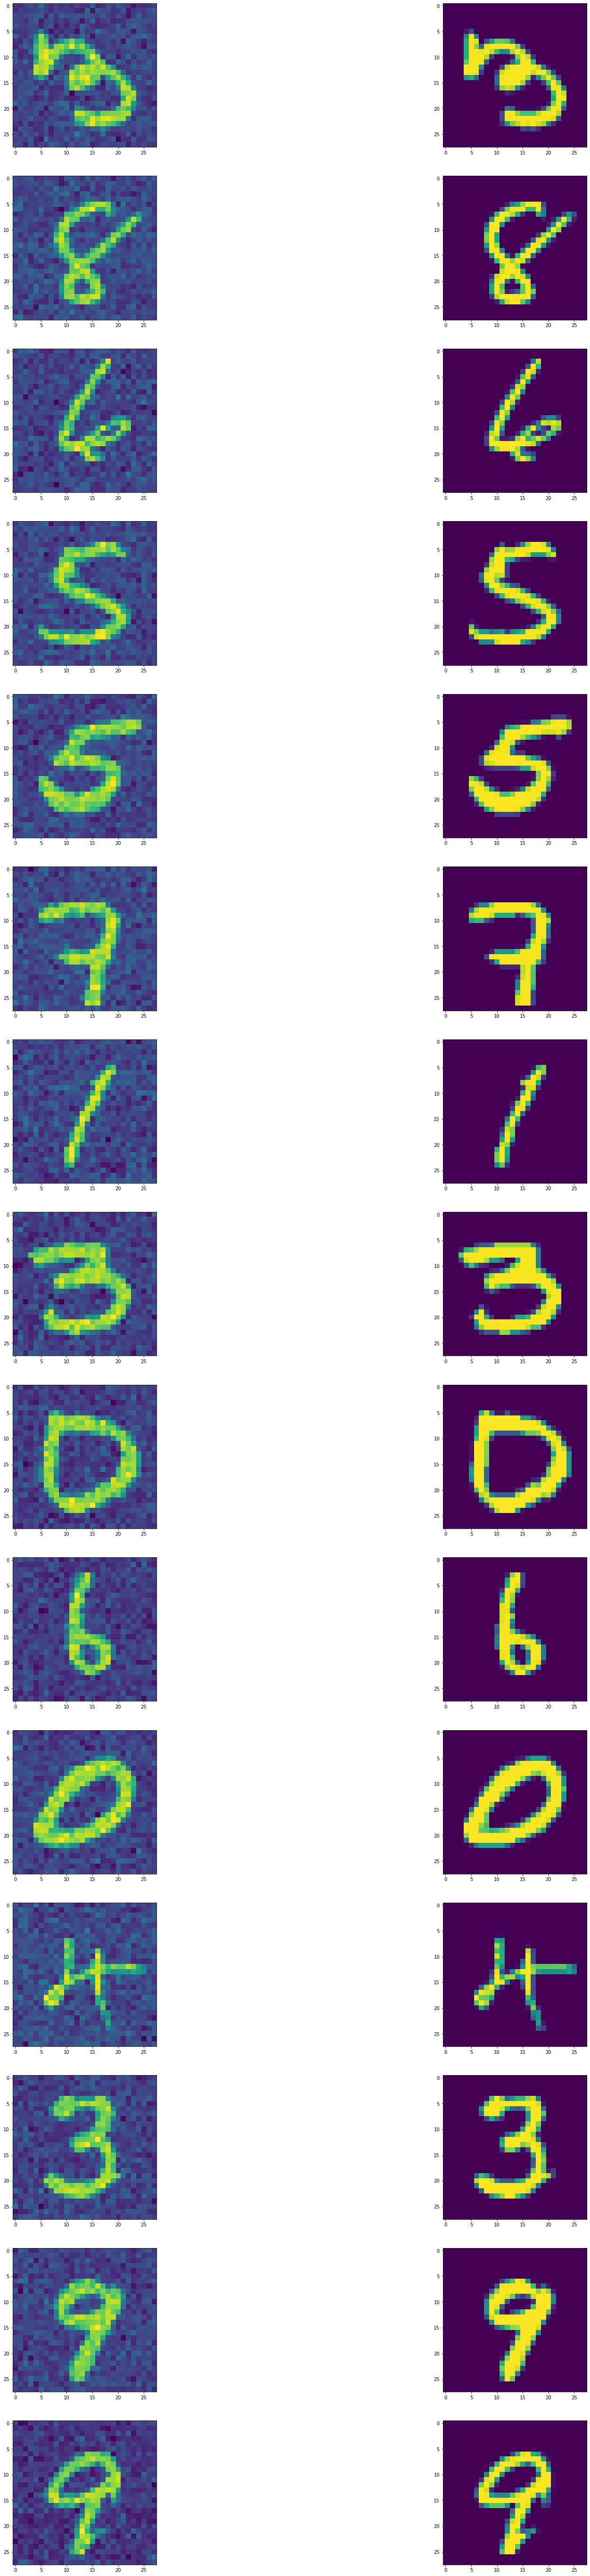

In [205]:
import matplotlib.pyplot as plt
nrow =15
ncol = 2

f, axarr = plt.subplots(nrow,ncol, figsize=(30,100))

rand_choice = torch.randint(len(dataset), (nrow,))

for i, axrow in enumerate(axarr):
    axrow[0].imshow(dataset[rand_choice[i]][0][0])
    axrow[1].imshow(dataset[rand_choice[i]][1][0])

In [196]:
TRAIN_LOSSES = []
VAL_LOSSES = []
for epoch in range(20):

    train_loss = AverageMeter('Train Loss', ':.4e')

    val_loss = AverageMeter('Train Loss', ':.4e')

    for x, y in train_loader:
 
        x = x.to(device)
        y = y.to(device)
 
        y_hat = model(x)
        loss = criterion(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item())


    
    with torch.no_grad():
        for x, y in val_loader:
 
            x = x.to(device)
            y = y.to(device)
 
            y_hat = model(x)
            loss = criterion(y_hat, y)

            val_loss.update(loss.item())

    
    TRAIN_LOSSES.append(train_loss.get_avg())
    VAL_LOSSES.append(val_loss.get_avg())

    print(f'Epoch {epoch}: Train Loss: {train_loss.get_avg():.6f} Val Loss {val_loss.get_avg():.6f}')
        

Epoch 0: Train Loss: 0.051826 Val Loss 0.041626
Epoch 1: Train Loss: 0.039204 Val Loss 0.038805
Epoch 2: Train Loss: 0.037075 Val Loss 0.036487
Epoch 3: Train Loss: 0.035580 Val Loss 0.035636
Epoch 4: Train Loss: 0.034580 Val Loss 0.034115
Epoch 5: Train Loss: 0.033944 Val Loss 0.034565
Epoch 6: Train Loss: 0.033633 Val Loss 0.034523
Epoch 7: Train Loss: 0.033107 Val Loss 0.033296
Epoch 8: Train Loss: 0.033007 Val Loss 0.032839
Epoch 9: Train Loss: 0.032532 Val Loss 0.032965
Epoch 10: Train Loss: 0.032222 Val Loss 0.032474
Epoch 11: Train Loss: 0.031949 Val Loss 0.033028
Epoch 12: Train Loss: 0.031757 Val Loss 0.034307
Epoch 13: Train Loss: 0.031710 Val Loss 0.032556
Epoch 14: Train Loss: 0.031394 Val Loss 0.032044
Epoch 15: Train Loss: 0.031306 Val Loss 0.032471
Epoch 16: Train Loss: 0.031246 Val Loss 0.031013
Epoch 17: Train Loss: 0.030990 Val Loss 0.032490
Epoch 18: Train Loss: 0.030828 Val Loss 0.031839
Epoch 19: Train Loss: 0.030664 Val Loss 0.031313


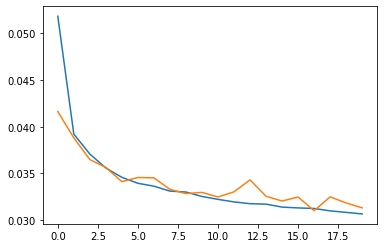

In [197]:
plt.plot(TRAIN_LOSSES)
plt.plot(VAL_LOSSES)

In [198]:
with torch.no_grad():
  x, y = next(iter(train_loader))
  x = x.to(device)
  y_hat = model(x)

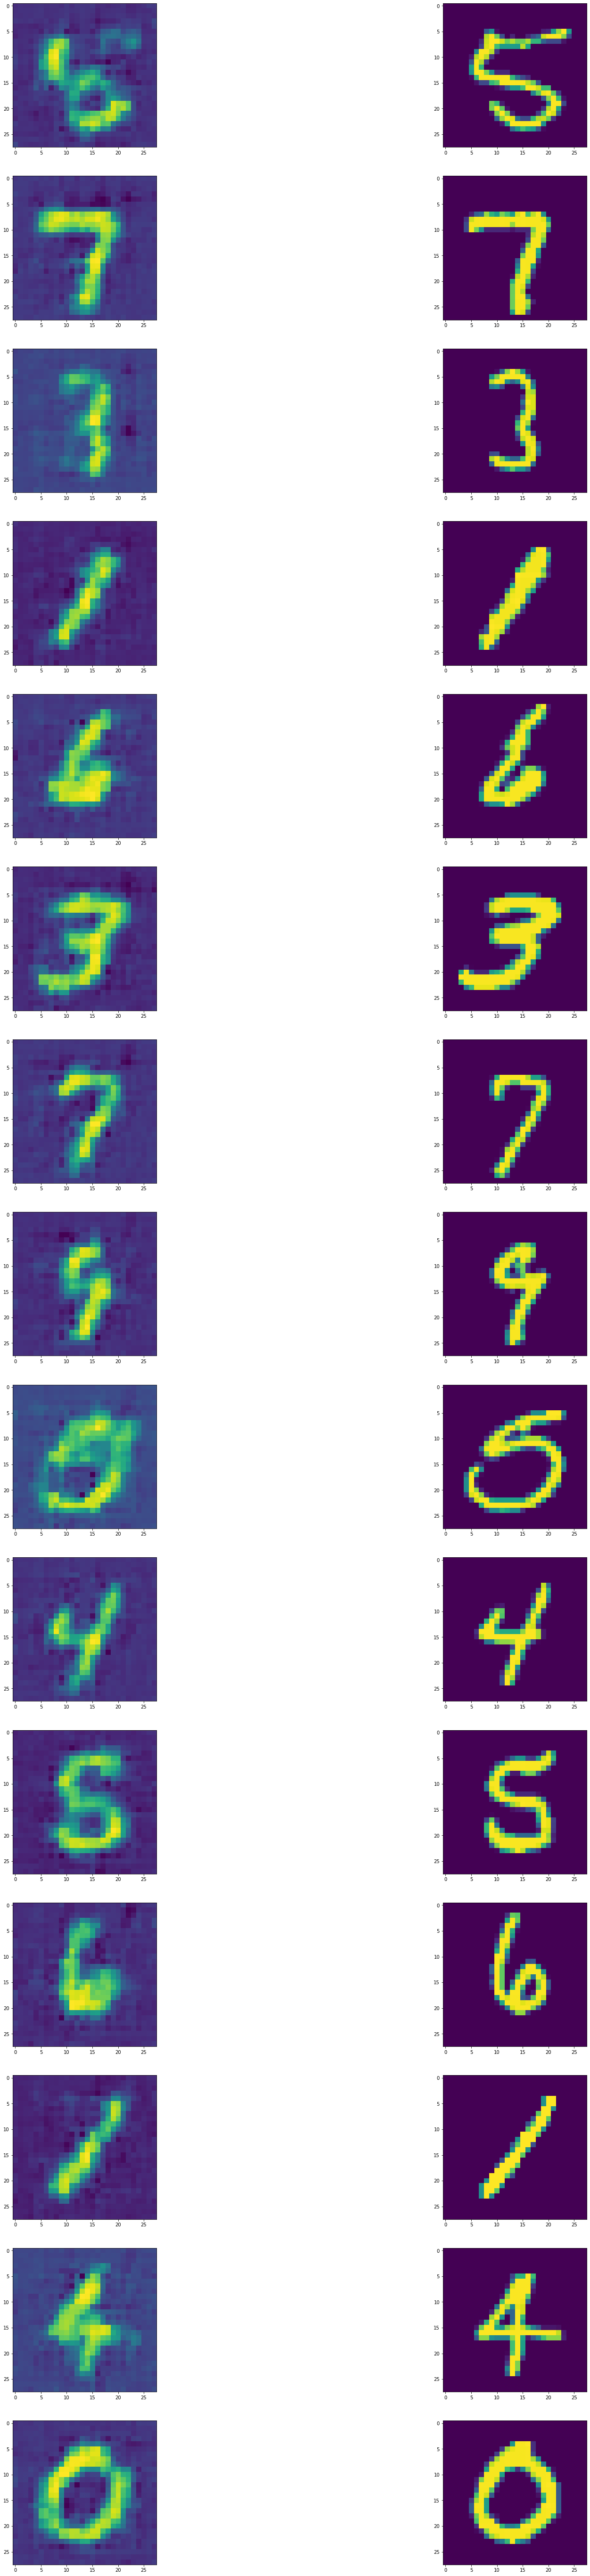

In [204]:
nrow =15
ncol = 2

f, axarr = plt.subplots(nrow,ncol, figsize=(30,100))

for i, axrow in enumerate(axarr):
  axrow[0].imshow(y_hat[i+100][0].to('cpu'))
  axrow[1].imshow(y[i+100][0].to('cpu'))
